In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # Ignore warning message

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)

In [2]:
# 변수 지정
df_cats = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')
df_train = pd.read_csv('sales_train.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [df_train, df_shops, df_items, df_cats, df_test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [4]:
# Extract data with a item_price greater than 0
df_train = df_train[df_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
df_train = df_train[df_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
df_train = df_train[df_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
df_train = df_train[df_train['item_cnt_day'] < 1000]

In [5]:
print(df_shops['shop_name'][0], '||', df_shops['shop_name'][57])
print(df_shops['shop_name'][1], '||', df_shops['shop_name'][58])
print(df_shops['shop_name'][10], '||', df_shops['shop_name'][11])
print(df_shops['shop_name'][39], '||', df_shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [6]:
#  Modify shop_id in sales_train data
df_train.loc[df_train['shop_id'] == 0, 'shop_id'] = 57
df_train.loc[df_train['shop_id'] == 1, 'shop_id'] = 58
df_train.loc[df_train['shop_id'] == 10, 'shop_id'] = 11
df_train.loc[df_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
df_test.loc[df_test['shop_id'] == 0, 'shop_id'] = 57
df_test.loc[df_test['shop_id'] == 1, 'shop_id'] = 58
df_test.loc[df_test['shop_id'] == 10, 'shop_id'] = 11
df_test.loc[df_test['shop_id'] == 39, 'shop_id'] = 40

In [7]:
# Leaking to imporve performance
unique_test_shop_id = df_test['shop_id'].unique()
df_train = df_train[df_train['shop_id'].isin(unique_test_shop_id)]

#### shops_preprocessing

In [8]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops['category'] = df_shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
df_shops.category.unique()

df_shops.groupby(['category']).sum()

shop_id
category              
etc               68.0
Магазин           22.0
Орджоникидзе,     57.0
ТК               184.0
ТРК              140.0
ТРЦ              340.0
ТЦ               883.0
склад             55.0
ул.               21.0

In [9]:
category = ['ТК', 'ТРК', 'ТРЦ', 'ТЦ']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', df_shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc         223.0
ТК          184.0
ТРК         140.0
ТРЦ         340.0
ТЦ          883.0


In [10]:
df_shops['shop_city'] = df_shops.city
df_shops['shop_category'] = df_shops.category

df_shops['shop_city'] = LabelEncoder().fit_transform(df_shops['shop_city'])
df_shops['shop_category'] = LabelEncoder().fit_transform(df_shops['shop_category'])

df_shops = df_shops[['shop_id','shop_city','shop_category']]
df_shops.head()

shop_id  shop_city  shop_category
0        0         29              0
1        1         29              4
2        2          0              4
3        3          1              2
4        4          2              4

#### item_preprocessing

In [11]:
import re
from collections import Counter
from operator import itemgetter

df_items['name_1'], df_items['name_2'] = df_items['item_name'].str.split('[', 1).str
df_items['name_1'], df_items['name_3'] = df_items['item_name'].str.split('(', 1).str

df_items['name_2'] = df_items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items['name_3'] = df_items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items = df_items.fillna('0')

result_1 = Counter(' '.join(df_items['name_2'].values.tolist()).split(' ')).items() # 키와 값들의 쌍을 얻을 수 있는 함수
result_1 = sorted(result_1, key=itemgetter(1)) # itemgetter(1) 0이면 key, 1이면 value 로 정렬
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)] # 논의사항1

result_2 = Counter(' '.join(df_items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [12]:
df_items['type'] = df_items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
df_items['type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', '', 'p', 'mac',
       'psp', 'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360',
       'русская', 'рс', 'android', 'англ', 'ps2', 'только', 'цифров',
       '6jv', 'j72', 'hm3', 's3v', '6dv', '6l6', '5f4', 's4v', 'kg4',
       '5c5', '5c7', 'kf7', 'kf6'], dtype=object)

In [13]:
df_items.loc[(df_items.type == 'x360') | (df_items.type == 'xbox360'), 'type'] = 'xbox 360'
df_items.loc[df_items.type == '', 'type'] = 'mac'
df_items.type = df_items.type.apply(lambda x: x.replace(' ',''))
df_items.loc[(df_items.type == 'pc')|(df_items.type == 'pс')|(df_items.type == 'рс'), 'type'] = 'pc'
df_items.loc[(df_items.type == 'рs3'), 'type'] = 'ps3'

In [14]:
group_sum = df_items.groupby('type').sum()
group_sum.head()

item_id  item_category_id
type                               
0     218310960.0          872182.0
5c5       12118.0              16.0
5c7       26808.0              32.0
5f4        7936.0               7.0
6dv        7934.0               7.0

In [15]:
group_sum.loc[group_sum.item_category_id < 200]

item_id  item_category_id
type                              
5c5      12118.0              16.0
5c7      26808.0              32.0
5f4       7936.0               7.0
6dv       7934.0               7.0
6jv       7924.0               7.0
6l6       7935.0               7.0
android  12994.0              78.0
hm3       7926.0               7.0
j72      31709.0              28.0
kf6      13403.0              16.0
kf7      13402.0              16.0
kg4      12117.0              16.0
p          721.0              78.0
ps2       7076.0              36.0
s3v       7933.0               7.0
s4v       7937.0               7.0
англ      2821.0              28.0
русская   1547.0              25.0
только   60074.0             156.0
цифров    3864.0              54.0

In [16]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

df_items.name_2 = df_items.type.apply(lambda x: 'etc' if x in drop_list else x)
df_items = df_items.drop(['type'], axis=1)
df_items.groupby('name_2').sum()

item_id  item_category_id
name_2                                 
0         218310960.0          872182.0
etc          249594.0             496.0
mac          148022.0            2245.0
p               721.0              78.0
pc         16991083.0          106924.0
ps           431537.0            1738.0
ps3         3531772.0           11422.0
ps4          895981.0            3489.0
psp          692947.0            2415.0
xbox360     2362398.0           10718.0
xboxone      566890.0            2952.0
цифров         3864.0              54.0
цифровая    1557596.0           11553.0

In [17]:
df_items['name_2'] = LabelEncoder().fit_transform(df_items['name_2'])
df_items['name_3'] = LabelEncoder().fit_transform(df_items['name_3'])
df_items.drop(['item_name','name_1'], axis=1, inplace=True)
df_items.head()

item_id  item_category_id  name_2  name_3
0        0                40       0    1331
1        1                76       4      42
2        2                40       0    1011
3        3                40       0    1010
4        4                40       0    1572

In [18]:
df_items['first_sale_date'] = df_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

df_items.head()

item_id  item_category_id  name_2  name_3  first_sale_date
0        0                40       0    1331              NaN
1        1                76       4      42             15.0
2        2                40       0    1011              NaN
3        3                40       0    1010              NaN
4        4                40       0    1572              NaN

In [19]:
df_items[df_items['first_sale_date'].isna()]

item_id  item_category_id  name_2  name_3  first_sale_date
0            0                40       0    1331              NaN
2            2                40       0    1011              NaN
3            3                40       0    1010              NaN
4            4                40       0    1572              NaN
5            5                40       0    1008              NaN
...        ...               ...     ...     ...              ...
21975    21975                61       0      42              NaN
22022    22022                40       0     952              NaN
22028    22028                40       0      42              NaN
22035    22035                40       0      42              NaN
22137    22137                40       0      42              NaN

[1090 rows x 5 columns]

In [20]:
# Replace NaN of first_sale_date with 34
df_items['first_sale_date'] = df_items['first_sale_date'].fillna(34)

In [21]:
df_items.head()

item_id  item_category_id  name_2  name_3  first_sale_date
0        0                40       0    1331             34.0
1        1                76       4      42             15.0
2        2                40       0    1011             34.0
3        3                40       0    1010             34.0
4        4                40       0    1572             34.0

#### category preprocessing

In [22]:
df_cats.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [23]:
df_cats['type_code'] = df_cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
df_cats.loc[(df_cats.type_code == 'Игровые') | (df_cats.type_code == 'Аксессуары'), 'category'] = 'Игры'
df_cats.loc[df_cats.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

df_cats['type_code'] = df_cats.type_code.apply(lambda x: x if (x in category) else 'etc')

print(df_cats.groupby(['type_code']).sum())

           item_category_id
type_code                  
etc                   236.0
Игры                  343.0
Карты                 170.0
Кино                  195.0
Книги                 624.0
Музыка                345.0
Подарки               798.0
Программы             453.0
Служебные             159.0
Чистые                163.0


In [24]:
df_cats['type_code'] = LabelEncoder().fit_transform(df_cats['type_code'])
df_cats.head()

item_category_name  item_category_id  type_code category
0  PC - Гарнитуры/Наушники                 0          0   Музыка
1         Аксессуары - PS2                 1          0     Игры
2         Аксессуары - PS3                 2          0     Игры
3         Аксессуары - PS4                 3          0     Игры
4         Аксессуары - PSP                 4          0     Игры

In [25]:
df_cats['split'] = df_cats.item_category_name.apply(lambda x: x.split('-'))
df_cats['subtype'] = df_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_cats['subtype_code'] = LabelEncoder().fit_transform(df_cats['subtype'])
df_cats = df_cats[['item_category_id', 'type_code', 'subtype_code']]

In [26]:
df_cats.head()

item_category_id  type_code  subtype_code
0                 0          0            29
1                 1          0             9
2                 2          0            10
3                 3          0            11
4                 4          0            13

In [27]:
df_items.head()

item_id  item_category_id  name_2  name_3  first_sale_date
0        0                40       0    1331             34.0
1        1                76       4      42             15.0
2        2                40       0    1011             34.0
3        3                40       0    1010             34.0
4        4                40       0    1572             34.0

In [28]:
df_shops.head()

shop_id  shop_city  shop_category
0        0         29              0
1        1         29              4
2        2          0              4
3        3          1              2
4        4          2              4

In [29]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in df_train['date_block_num'].unique():
    all_shop = df_train.loc[df_train['date_block_num']==i, 'shop_id'].unique()
    all_item = df_train.loc[df_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [30]:
group = df_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean
0               0       59    22154             1.0            999.0
1               0       59     2552             NaN              NaN
2               0       59     2554             NaN              NaN
3               0       59     2555             NaN              NaN
4               0       59     2564             NaN              NaN

In [31]:
import gc

# group variable garbage collection
del group
gc.collect();

In [32]:
# Add a feature for the number of items sold
group = df_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group
gc.collect()

train.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               0       59    22154             1.0            999.0   
1               0       59     2552             NaN              NaN   
2               0       59     2554             NaN              NaN   
3               0       59     2555             NaN              NaN   
4               0       59     2564             NaN              NaN   

   item_count  
0         1.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [33]:
# Set test data date_block_num to 34
df_test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, df_test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               0       59    22154             1.0            999.0   
1               0       59     2552             0.0              0.0   
2               0       59     2554             0.0              0.0   
3               0       59     2555             0.0              0.0   
4               0       59     2564             0.0              0.0   

   item_count  
0         1.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [34]:
df_cats.head()

item_category_id  type_code  subtype_code
0                 0          0            29
1                 1          0             9
2                 2          0            10
3                 3          0            11
4                 4          0            13

In [35]:
# Merge other data
all_data = all_data.merge(df_shops, on='shop_id', how='left')
all_data = all_data.merge(df_items, on='item_id', how='left')
all_data = all_data.merge(df_cats, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del df_shops, df_items, df_cats
gc.collect();

61.6% compressed


In [36]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [37]:
resumetable(all_data)

Data Shape: (8856961, 14)


Dtypes  Null  Uniques  First_values  Second_values  \
date_block_num       int8     0       35           0.0            0.0   
shop_id              int8     0       42          59.0           59.0   
item_id             int16     0    21464       22154.0         2552.0   
item_cnt_month      int16     0      407           1.0            0.0   
item_price_mean   float32     0    34147         999.0            0.0   
item_count           int8     0       40           1.0            0.0   
shop_city            int8     0       28          30.0           30.0   
shop_category        int8     0        5           4.0            4.0   
item_category_id     int8     0       84          37.0           58.0   
name_2               int8     0       13           0.0            0.0   
name_3              int16     0     1639         562.0           42.0   
first_sale_date      int8     0       35           0.0            0.0   
type_code            int8     0       10           3.0            5.0   
subtype_code         int8     0       65           1.0           27.0   

                  Third_values  
date_block_num             0.0  
shop_id                   59.0  
item_id                 2554.0  
item_cnt_month             0.0  
item_price_mean            0.0  
item_count                 0.0  
shop_city                 30.0  
shop_category              4.0  
item_category_id          58.0  
name_2                     0.0  
name_3                    42.0  
first_sale_date            0.0  
type_code                  5.0  
subtype_code              27.0

#### Visualization

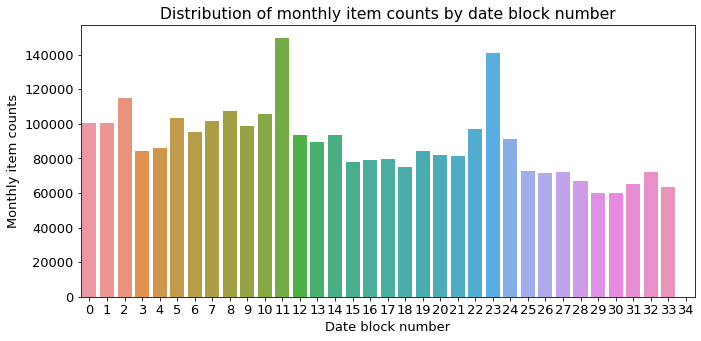

In [38]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

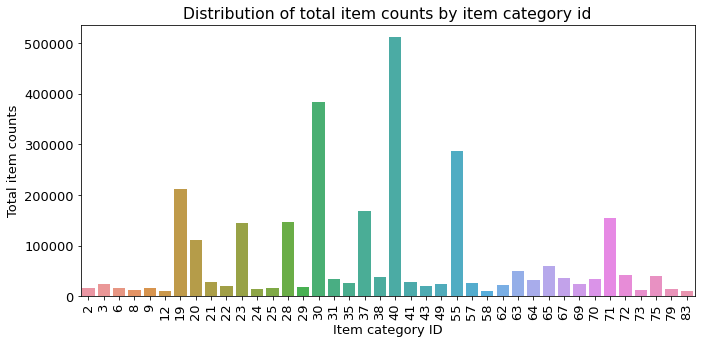

In [39]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

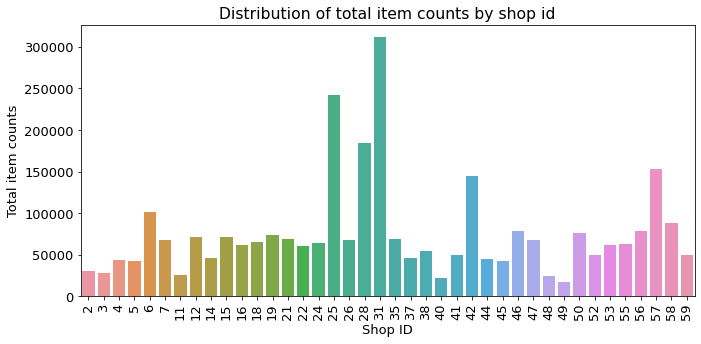

In [40]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

#### Create lags features

In [41]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [42]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'shop_city'])

In [43]:
item_mean_features

['item_id_mean_sales', 'item_id_shop_city_mean_sales']

In [44]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [45]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [46]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += i
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [47]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [48]:
all_data.head().T

0            1            2  \
date_block_num                           0.000000     0.000000     0.000000   
shop_id                                 59.000000    59.000000    59.000000   
item_id                              22154.000000  2552.000000  2554.000000   
item_cnt_month                           1.000000     0.000000     0.000000   
item_price_mean                        999.000000     0.000000     0.000000   
item_count                               1.000000     0.000000     0.000000   
shop_city                               30.000000    30.000000    30.000000   
shop_category                            4.000000     4.000000     4.000000   
item_category_id                        37.000000    58.000000    58.000000   
name_2                                   0.000000     0.000000     0.000000   
name_3                                 562.000000    42.000000    42.000000   
first_sale_date                          0.000000     0.000000     0.000000   
type_code                                3.000000     5.000000     5.000000   
subtype_code                             1.000000    27.000000    27.000000   
item_id_mean_sales                       0.457143     0.028571     0.028571   
item_id_shop_city_mean_sales             1.000000     0.000000     0.000000   
shop_id_item_category_id_mean_sales      0.096774     0.000000     0.000000   
item_cnt_month_lag1                      0.000000     0.000000     0.000000   
item_cnt_month_lag2                      0.000000     0.000000     0.000000   
item_cnt_month_lag3                      0.000000     0.000000     0.000000   

                                               3            4  
date_block_num                          0.000000     0.000000  
shop_id                                59.000000    59.000000  
item_id                              2555.000000  2564.000000  
item_cnt_month                          0.000000     0.000000  
item_price_mean                         0.000000     0.000000  
item_count                              0.000000     0.000000  
shop_city                              30.000000    30.000000  
shop_category                           4.000000     4.000000  
item_category_id                       56.000000    59.000000  
name_2                                  0.000000     0.000000  
name_3                               1632.000000  1199.000000  
first_sale_date                         0.000000     0.000000  
type_code                               5.000000     5.000000  
subtype_code                            3.000000    40.000000  
item_id_mean_sales                      0.028571     0.142857  
item_id_shop_city_mean_sales            0.000000     0.000000  
shop_id_item_category_id_mean_sales     0.011494     0.013245  
item_cnt_month_lag1                     0.000000     0.000000  
item_cnt_month_lag2                     0.000000     0.000000  
item_cnt_month_lag3                     0.000000     0.000000

In [49]:
# all_data.drop(columns='item_id_mean_sales_y', axis=1, inplace=True)

In [50]:
all_data.rename(columns={'item_id_mean_sales_x':'item_id_mean_sales'}, inplace=True)

In [51]:
all_data.head().T

0            1            2  \
date_block_num                           0.000000     0.000000     0.000000   
shop_id                                 59.000000    59.000000    59.000000   
item_id                              22154.000000  2552.000000  2554.000000   
item_cnt_month                           1.000000     0.000000     0.000000   
item_price_mean                        999.000000     0.000000     0.000000   
item_count                               1.000000     0.000000     0.000000   
shop_city                               30.000000    30.000000    30.000000   
shop_category                            4.000000     4.000000     4.000000   
item_category_id                        37.000000    58.000000    58.000000   
name_2                                   0.000000     0.000000     0.000000   
name_3                                 562.000000    42.000000    42.000000   
first_sale_date                          0.000000     0.000000     0.000000   
type_code                                3.000000     5.000000     5.000000   
subtype_code                             1.000000    27.000000    27.000000   
item_id_mean_sales                       0.457143     0.028571     0.028571   
item_id_shop_city_mean_sales             1.000000     0.000000     0.000000   
shop_id_item_category_id_mean_sales      0.096774     0.000000     0.000000   
item_cnt_month_lag1                      0.000000     0.000000     0.000000   
item_cnt_month_lag2                      0.000000     0.000000     0.000000   
item_cnt_month_lag3                      0.000000     0.000000     0.000000   

                                               3            4  
date_block_num                          0.000000     0.000000  
shop_id                                59.000000    59.000000  
item_id                              2555.000000  2564.000000  
item_cnt_month                          0.000000     0.000000  
item_price_mean                         0.000000     0.000000  
item_count                              0.000000     0.000000  
shop_city                              30.000000    30.000000  
shop_category                           4.000000     4.000000  
item_category_id                       56.000000    59.000000  
name_2                                  0.000000     0.000000  
name_3                               1632.000000  1199.000000  
first_sale_date                         0.000000     0.000000  
type_code                               5.000000     5.000000  
subtype_code                            3.000000    40.000000  
item_id_mean_sales                      0.028571     0.142857  
item_id_shop_city_mean_sales            0.000000     0.000000  
shop_id_item_category_id_mean_sales     0.011494     0.013245  
item_cnt_month_lag1                     0.000000     0.000000  
item_cnt_month_lag2                     0.000000     0.000000  
item_cnt_month_lag3                     0.000000     0.000000

In [52]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [53]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [54]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales              0.0
item_id_shop_city_mean_sales    0.0
dtype: float32

In [55]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [56]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [57]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [58]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [59]:
all_data.head(3)

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
827196               3       25     8092               3            149.0   
827197               3       25     7850               3            199.0   
827198               3       25     8051               3             30.0   

        item_count  shop_city  shop_category  item_category_id  name_2  \
827196           3         13              2                40       0   
827197           3         13              2                30       4   
827198           2         13              2                66       0   

        name_3  first_sale_date  type_code  subtype_code  item_cnt_month_lag1  \
827196      42                0          3             4                    1   
827197      42                0          1            55                    5   
827198      42                0          6            47                    0   

        item_cnt_month_lag2  item_cnt_month_lag3  item_count_lag1  \
827196                    4                    0                1   
827197                    6                    0                4   
827198                    0                    0                0   

        item_count_lag2  item_count_lag3  item_price_mean_lag1  \
827196                4                0                 149.0   
827197                5                0                 199.0   
827198                0                0                   0.0   

        item_price_mean_lag2  item_price_mean_lag3  item_id_mean_sales_lag1  \
827196                 149.0                   0.0                 0.666667   
827197                 199.0                   0.0                 2.000000   
827198                   0.0                   0.0                 0.027778   

        item_id_mean_sales_lag2  item_id_mean_sales_lag3  \
827196                 1.428571                      0.0   
827197                 3.114286                      0.0   
827198                 0.085714                      0.0   

        item_id_shop_city_mean_sales_lag1  item_id_shop_city_mean_sales_lag2  \
827196                           1.000000                           2.142857   
827197                           3.714286                           2.285714   
827198                           0.000000                           0.428571   

        item_id_shop_city_mean_sales_lag3  \
827196                                0.0   
827197                                0.0   
827198                                0.0   

        shop_id_item_category_id_mean_sales_lag1  \
827196                                  1.087262   
827197                                  3.654494   
827198                                  1.827586   

        shop_id_item_category_id_mean_sales_lag2  \
827196                                  1.049296   
827197                                  2.279188   
827198                                  1.389474   

        shop_id_item_category_id_mean_sales_lag3  
827196                                       0.0  
827197                                       0.0  
827198                                       0.0

In [60]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()  # for문 안에서 돌 때마다 새로운 copy를 찍어내기 때문에 누적합(+=i)이 되지 않음.
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [61]:
df_train.head()

date  date_block_num  shop_id  item_id   item_price  item_cnt_day
0  02.01.2013               0       59    22154   999.000000             1
1  03.01.2013               0       25     2552   899.000000             1
3  06.01.2013               0       25     2554  1709.050049             1
4  15.01.2013               0       25     2555  1099.000000             1
5  10.01.2013               0       25     2564   349.000000             1

In [62]:
# 월별, shop_id, subtype_code별 매출량 평균
group = all_data.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
group.head()

date_block_num  shop_id  subtype_code  date_shop_subtype_avg_item_cnt
0               3        2             0                        0.500000
1               3        2             1                        0.038882
2               3        2             2                        0.006289
3               3        2             3                        0.000000
4               3        2             4                        0.019912

In [63]:
all_data = pd.merge(all_data,group, on=['date_block_num','shop_id','subtype_code'], how='left')
all_data['date_shop_subtype_avg_item_cnt'] = all_data['date_shop_subtype_avg_item_cnt'].astype(np.float16)
all_data = lag_feature(all_data, [1,2,3], 'date_shop_subtype_avg_item_cnt')
all_data.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [64]:
all_data.head(3)

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               3       25     8092               3            149.0   
1               3       25     7850               3            199.0   
2               3       25     8051               3             30.0   

   item_count  shop_city  shop_category  item_category_id  name_2  name_3  \
0           3         13              2                40       0      42   
1           3         13              2                30       4      42   
2           2         13              2                66       0      42   

   first_sale_date  type_code  subtype_code  item_cnt_month_lag1  \
0                0          3             4                    1   
1                0          1            55                    5   
2                0          6            47                    0   

   item_cnt_month_lag2  item_cnt_month_lag3  item_count_lag1  item_count_lag2  \
0                    4                    0                1                4   
1                    6                    0                4                5   
2                    0                    0                0                0   

   item_count_lag3  item_price_mean_lag1  item_price_mean_lag2  \
0                0                 149.0                 149.0   
1                0                 199.0                 199.0   
2                0                   0.0                   0.0   

   item_price_mean_lag3  item_id_mean_sales_lag1  item_id_mean_sales_lag2  \
0                   0.0                 0.666667                 1.428571   
1                   0.0                 2.000000                 3.114286   
2                   0.0                 0.027778                 0.085714   

   item_id_mean_sales_lag3  item_id_shop_city_mean_sales_lag1  \
0                      0.0                           1.000000   
1                      0.0                           3.714286   
2                      0.0                           0.000000   

   item_id_shop_city_mean_sales_lag2  item_id_shop_city_mean_sales_lag3  \
0                           2.142857                                0.0   
1                           2.285714                                0.0   
2                           0.428571                                0.0   

   shop_id_item_category_id_mean_sales_lag1  \
0                                  1.087262   
1                                  3.654494   
2                                  1.827586   

   shop_id_item_category_id_mean_sales_lag2  \
0                                  1.049296   
1                                  2.279188   
2                                  1.389474   

   shop_id_item_category_id_mean_sales_lag3  \
0                                       0.0   
1                                       0.0   
2                                       0.0   

   date_shop_subtype_avg_item_cnt_lag_1  date_shop_subtype_avg_item_cnt_lag_2  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   

   date_shop_subtype_avg_item_cnt_lag_3  
0                                   NaN  
1                                   NaN  
2                                   NaN

In [65]:
# group = all_data.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
# group.columns = ['date_item_city_avg_item_cnt']
# group.reset_index(inplace=True)

# all_data = pd.merge(all_data, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
# all_data['date_item_city_avg_item_cnt'] = all_data['date_item_city_avg_item_cnt'].astype(np.float16)
# all_data = lag_feature(all_data, [1], 'date_item_city_avg_item_cnt')
# all_data.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [66]:
group = all_data.groupby(['date_block_num','shop_id' ,'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','shop_id' ,'item_id'], how='left')
all_data['date_shop_item_avg_item_cnt'] = all_data['date_shop_item_avg_item_cnt'].astype(np.float16)
all_data = lag_feature(all_data, [1,2,3], 'date_shop_item_avg_item_cnt')
all_data.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)

In [67]:
# item_id별 
group = df_train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

all_data = pd.merge(all_data,group, on=['item_id'], how='left')
all_data['item_avg_item_price'] = all_data['item_avg_item_price'].astype(np.float16)

group = df_train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

all_data = pd.merge(all_data,group, on=['date_block_num','item_id'], how='left')
all_data['date_item_avg_item_price'] = all_data['date_item_avg_item_price'].astype(np.float16)

In [68]:
all_data = lag_feature(all_data, [1,2,3,6,12], 'date_item_avg_item_price')

In [69]:
all_data.head(3)

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               3       25     8092               3            149.0   
1               3       25     7850               3            199.0   
2               3       25     8051               3             30.0   

   item_count  shop_city  shop_category  item_category_id  name_2  name_3  \
0           3         13              2                40       0      42   
1           3         13              2                30       4      42   
2           2         13              2                66       0      42   

   first_sale_date  type_code  subtype_code  item_cnt_month_lag1  \
0                0          3             4                    1   
1                0          1            55                    5   
2                0          6            47                    0   

   item_cnt_month_lag2  item_cnt_month_lag3  item_count_lag1  item_count_lag2  \
0                    4                    0                1                4   
1                    6                    0                4                5   
2                    0                    0                0                0   

   item_count_lag3  item_price_mean_lag1  item_price_mean_lag2  \
0                0                 149.0                 149.0   
1                0                 199.0                 199.0   
2                0                   0.0                   0.0   

   item_price_mean_lag3  item_id_mean_sales_lag1  item_id_mean_sales_lag2  \
0                   0.0                 0.666667                 1.428571   
1                   0.0                 2.000000                 3.114286   
2                   0.0                 0.027778                 0.085714   

   item_id_mean_sales_lag3  item_id_shop_city_mean_sales_lag1  \
0                      0.0                           1.000000   
1                      0.0                           3.714286   
2                      0.0                           0.000000   

   item_id_shop_city_mean_sales_lag2  item_id_shop_city_mean_sales_lag3  \
0                           2.142857                                0.0   
1                           2.285714                                0.0   
2                           0.428571                                0.0   

   shop_id_item_category_id_mean_sales_lag1  \
0                                  1.087262   
1                                  3.654494   
2                                  1.827586   

   shop_id_item_category_id_mean_sales_lag2  \
0                                  1.049296   
1                                  2.279188   
2                                  1.389474   

   shop_id_item_category_id_mean_sales_lag3  \
0                                       0.0   
1                                       0.0   
2                                       0.0   

   date_shop_subtype_avg_item_cnt_lag_1  date_shop_subtype_avg_item_cnt_lag_2  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   

   date_shop_subtype_avg_item_cnt_lag_3  date_shop_item_avg_item_cnt_lag_1  \
0                                   NaN                                NaN   
1                                   NaN                                NaN   
2                                   NaN                                NaN   

   date_shop_item_avg_item_cnt_lag_2  date_shop_item_avg_item_cnt_lag_3  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   

   item_avg_item_price  date_item_avg_item_price  \
0               148.25                     149.0   
1               197.25                     199.0   
2        

In [70]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [71]:
# all_data.drop(columns=['delta_price_lag','date_item_avg_item_price_y','item_avg_item_price_x','item_avg_item_price_y'], axis=1, inplace=True)

In [72]:
# all_data.rename(columns={'date_item_avg_item_price_x':'date_item_avg_item_price'}, inplace=True)

In [73]:
all_data.head(3)

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               3       25     8092               3            149.0   
1               3       25     7850               3            199.0   
2               3       25     8051               3             30.0   

   item_count  shop_city  shop_category  item_category_id  name_2  name_3  \
0           3         13              2                40       0      42   
1           3         13              2                30       4      42   
2           2         13              2                66       0      42   

   first_sale_date  type_code  subtype_code  item_cnt_month_lag1  \
0                0          3             4                    1   
1                0          1            55                    5   
2                0          6            47                    0   

   item_cnt_month_lag2  item_cnt_month_lag3  item_count_lag1  item_count_lag2  \
0                    4                    0                1                4   
1                    6                    0                4                5   
2                    0                    0                0                0   

   item_count_lag3  item_price_mean_lag1  item_price_mean_lag2  \
0                0                 149.0                 149.0   
1                0                 199.0                 199.0   
2                0                   0.0                   0.0   

   item_price_mean_lag3  item_id_mean_sales_lag1  item_id_mean_sales_lag2  \
0                   0.0                 0.666667                 1.428571   
1                   0.0                 2.000000                 3.114286   
2                   0.0                 0.027778                 0.085714   

   item_id_mean_sales_lag3  item_id_shop_city_mean_sales_lag1  \
0                      0.0                           1.000000   
1                      0.0                           3.714286   
2                      0.0                           0.000000   

   item_id_shop_city_mean_sales_lag2  item_id_shop_city_mean_sales_lag3  \
0                           2.142857                                0.0   
1                           2.285714                                0.0   
2                           0.428571                                0.0   

   shop_id_item_category_id_mean_sales_lag1  \
0                                  1.087262   
1                                  3.654494   
2                                  1.827586   

   shop_id_item_category_id_mean_sales_lag2  \
0                                  1.049296   
1                                  2.279188   
2                                  1.389474   

   shop_id_item_category_id_mean_sales_lag3  \
0                                       0.0   
1                                       0.0   
2                                       0.0   

   date_shop_subtype_avg_item_cnt_lag_1  date_shop_subtype_avg_item_cnt_lag_2  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   

   date_shop_subtype_avg_item_cnt_lag_3  date_shop_item_avg_item_cnt_lag_1  \
0                                   NaN                                NaN   
1                                   NaN                                NaN   
2                                   NaN                                NaN   

   date_shop_item_avg_item_cnt_lag_2  date_shop_item_avg_item_cnt_lag_3  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   

   item_avg_item_price  date_item_avg_item_price  \
0               148.25                     149.0   
1               197.25                     199.0   
2        

In [74]:
# all_data.drop(columns='date_item_avg_item_price_y', axis=1, inplace=True)

In [75]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [76]:
# all_data.rename(columns={'date_item_avg_item_price_x':'data_item_avg_item_price'}, inplace=True)

In [77]:
# all_data.head(1)

In [78]:
# all_data.head(1)

In [79]:
# all_data.head(1)

In [80]:
# all_data.drop(columns=['date_item_avg_item_price_lag_1_y','date_item_avg_item_price_lag_2_y','date_item_avg_item_price_lag_3_y'],axis=1,inplace=True)

In [81]:
# all_data.rename(columns={'date_item_avg_item_price_lag_1_x':'date_item_avg_item_price_lag_1'},inplace=True)

In [82]:
# all_data.rename(columns={'date_item_avg_item_price_lag_2_x':'date_item_avg_item_price_lag_2'},inplace=True)

In [83]:
# all_data.rename(columns={'date_item_avg_item_price_lag_3_x':'date_item_avg_item_price_lag_3'},inplace=True)

In [84]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [85]:
# 몇 퍼 증가, 혹은 몇 퍼 하락했는지 알기 위해 >>> 추세
lags = [1,2,3,6,12]

for i in lags:
    all_data['delta_price_lag_'+str(i)] = (all_data['date_item_avg_item_price_lag_'+str(i)] - all_data['item_avg_item_price']) / all_data['item_avg_item_price']
    
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
all_data['delta_price_lag'] = all_data.apply(select_trend, axis=1)
all_data['delta_price_lag'] = all_data['delta_price_lag'].astype(np.float16)
all_data['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

all_data.drop(fetures_to_drop, axis=1, inplace=True)

In [86]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [87]:
df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']

In [88]:
df_train.head()

date  date_block_num  shop_id  item_id   item_price  item_cnt_day  \
0  02.01.2013               0       59    22154   999.000000             1   
1  03.01.2013               0       25     2552   899.000000             1   
3  06.01.2013               0       25     2554  1709.050049             1   
4  15.01.2013               0       25     2555  1099.000000             1   
5  10.01.2013               0       25     2564   349.000000             1   

       revenue  
0   999.000000  
1   899.000000  
3  1709.050049  
4  1099.000000  
5   349.000000

In [89]:
group = df_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','shop_id'], how='left')
all_data['date_shop_revenue'] = all_data['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['shop_id'], how='left')
all_data['shop_avg_revenue'] = all_data['shop_avg_revenue'].astype(np.float32)

all_data['delta_revenue'] = (all_data['date_shop_revenue'] - all_data['shop_avg_revenue']) / all_data['shop_avg_revenue']
all_data['delta_revenue'] = all_data['delta_revenue'].astype(np.float16)

all_data = lag_feature(all_data, [1,2,3,6,12], 'delta_revenue')

all_data.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [90]:
all_data['month'] = all_data['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)

In [91]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 0 to 8029764
Data columns (total 46 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int16  
 4   item_price_mean                           float32
 5   item_count                                int8   
 6   shop_city                                 int8   
 7   shop_category                             int8   
 8   item_category_id                          int8   
 9   name_2                                    int8   
 10  name_3                                    int16  
 11  first_sale_date                           int8   
 12  type_code                                 int8   
 13  subtype_code                              int8   
 14  it

In [92]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)

In [93]:
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [94]:
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [95]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

In [96]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

In [97]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 0 to 8029764
Data columns (total 48 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   shop_city                                 int8   
 5   shop_category                             int8   
 6   item_category_id                          int8   
 7   name_2                                    int8   
 8   name_3                                    int16  
 9   type_code                                 int8   
 10  subtype_code                              int8   
 11  item_cnt_month_lag1                       int8   
 12  item_cnt_month_lag2                       int8   
 13  item_cnt_month_lag3                       int8   
 14  it

In [98]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data
gc.collect();

In [99]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'shop_city', 'item_category_id', 'shop_category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)     

[LightGBM] [Info] Total Bins 6693
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 47
[LightGBM] [Info] Start training from score 0.307756
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01584	valid_1's rmse: 0.914325
[200]	training's rmse: 0.908756	valid_1's rmse: 0.84349
[300]	training's rmse: 0.853943	valid_1's rmse: 0.815691
[400]	training's rmse: 0.823769	valid_1's rmse: 0.804835
[500]	training's rmse: 0.803878	valid_1's rmse: 0.800902
[600]	training's rmse: 0.790084	valid_1's rmse: 0.799056
[700]	training's rmse: 0.779249	valid_1's rmse: 0.798086
[800]	training's rmse: 0.770213	valid_1's rmse: 0.797472
[900]	training's rmse: 0.762697	valid_1's rmse: 0.797546
[1000]	training's rmse: 0.756175	valid_1's rmse: 0.797493
[1100]	training's rmse: 0.750933	valid_1's rmse: 0.797442
Early stopping, best iteration is:
[969]	training's rmse: 0.758217	valid_1's rmse: 0.797247


In [100]:
preds = lgb_model.predict(X_test).clip(0,20)

df_submission['item_cnt_month'] = preds
df_submission.to_csv('submission-4.csv', index=False)

In [101]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='hist',
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:1.18600	validation_1-rmse:1.05588
[1]	validation_0-rmse:1.13406	validation_1-rmse:1.01389
[2]	validation_0-rmse:1.08917	validation_1-rmse:0.97779
[3]	validation_0-rmse:1.05016	validation_1-rmse:0.94664
[4]	validation_0-rmse:1.01657	validation_1-rmse:0.92067
[5]	validation_0-rmse:0.98825	validation_1-rmse:0.89910
[6]	validation_0-rmse:0.96399	validation_1-rmse:0.88220
[7]	validation_0-rmse:0.94246	validation_1-rmse:0.86695
[8]	validation_0-rmse:0.92375	validation_1-rmse:0.85529
[9]	validation_0-rmse:0.90774	validation_1-rmse:0.84551
[10]	validation_0-rmse:0.89400	validation_1-rmse:0.83675
[11]	validation_0-rmse:0.88182	validation_1-rmse:0.83093
[12]	validation_0-rmse:0.87086	validation_1-rmse:0.82536
[13]	validation_0-rmse:0.86196	validation_1-rmse:0.82019
[14]	validation_0-rmse:0.85423	validation_1-rmse:0.81645
[15]	validation_0-rmse:0.84750	validation_1-rmse:0.81329
[16]	validation_0-rmse:0.84146	validation_1-rmse:0.81113
[17]	validation_0-rmse:0.83603	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=0.5,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [102]:
y_pred = model.predict(X_valid).clip(0, 20)
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('xgb_submission(4).csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(y_test, open('xgb_test.pickle', 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

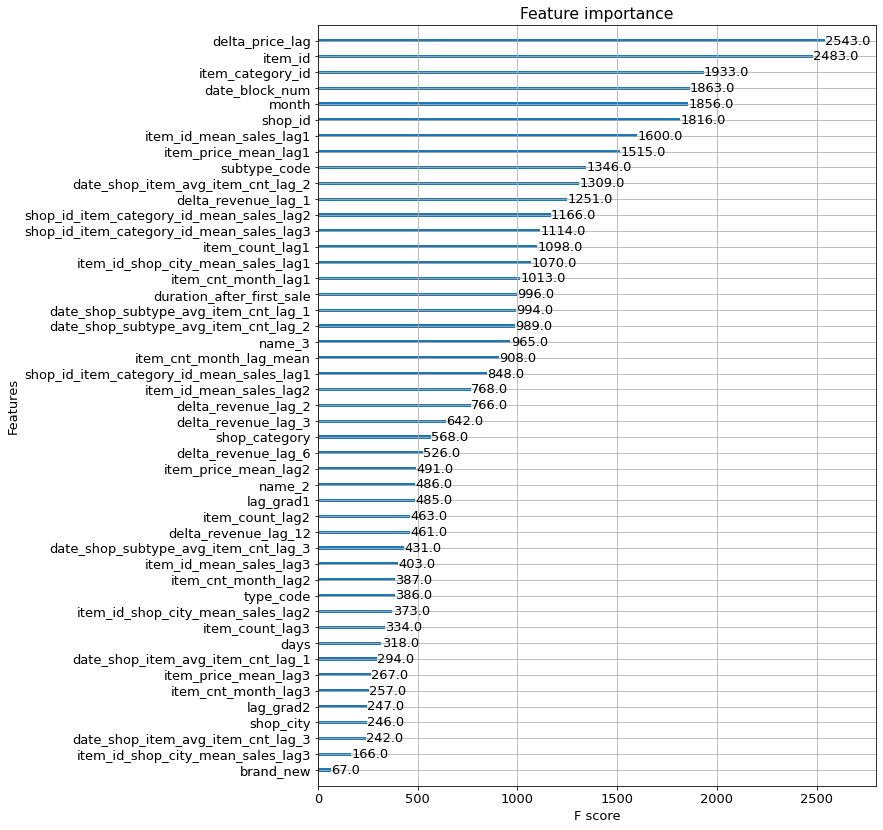

In [103]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))